# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score


In [2]:
le = preprocessing.LabelEncoder()

In [3]:
full_df = pd.read_csv('malicious_and_benign.csv')
test_df = pd.read_csv('malicious_and_benign_test.csv')


In [4]:
print(len(full_df))

1781


In [5]:
print(len(test_df))

357


In [6]:
train_df = pd.concat([full_df, test_df]).drop_duplicates(keep=False)

print(len(train_df))

1424


In [7]:
train_df.head(10)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0
5,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
8,M2_17,20,5,utf-8,nginx/1.10.1,NaN,None,None,8/11/2014 7:41,None,...,0,0,0,2,3,213,146,2,2.0,1
12,B0_22,20,7,utf-8,None,13716.0,GB,None,11/10/2002 0:00,6/10/2016 0:00,...,6,8,1492,20,20,2334,1784,20,4.0,0
13,B0_482,20,6,ISO-8859-1,nginx,3692.0,None,None,14/11/2002 0:00,19/04/2015 0:00,...,19,4,3946,35,29,16408,4746,35,10.0,0
14,B0_869,20,7,ISO-8859-1,Apache/2.2.15 (Red Hat),13054.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0


In [8]:
from sklearn.preprocessing import Imputer
for column in train_df:
    if train_df[column].dtype == object:
        train_df[column] = le.fit_transform(train_df[column].astype(str)).astype(float)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(train_df[[column]])
    train_df[column]=imp.transform(train_df[[column]])
train_df.head(20)



,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,1263.0,16.0,7.0,4.0,175.0,263.000000,27.0,85.0,47.0,526.0,...,0.0,2.0,700.0,9.0,10.0,1153.0,832.0,9.0,2.0,1.0
1,633.0,16.0,6.0,3.0,54.0,15087.000000,27.0,85.0,759.0,526.0,...,7.0,4.0,1230.0,17.0,19.0,1265.0,1230.0,17.0,0.0,0.0
2,1191.0,16.0,6.0,5.0,99.0,324.000000,27.0,85.0,759.0,526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,103.0,17.0,6.0,1.0,175.0,162.000000,39.0,4.0,689.0,54.0,...,22.0,3.0,3812.0,39.0,37.0,18784.0,4380.0,39.0,8.0,0.0
4,780.0,17.0,6.0,3.0,108.0,124140.000000,39.0,122.0,73.0,32.0,...,2.0,5.0,4278.0,61.0,62.0,129889.0,4586.0,61.0,4.0,0.0
5,441.0,18.0,7.0,3.0,175.0,12343.020539,32.0,61.0,548.0,389.0,...,6.0,9.0,894.0,11.0,13.0,838.0,894.0,11.0,0.0,0.0
8,1366.0,20.0,5.0,6.0,185.0,12343.020539,27.0,85.0,721.0,526.0,...,0.0,0.0,0.0,2.0,3.0,213.0,146.0,2.0,2.0,1.0
12,548.0,20.0,7.0,6.0,108.0,13716.000000,14.0,85.0,59.0,474.0,...,6.0,8.0,1492.0,20.0,20.0,2334.0,1784.0,20.0,4.0,0.0
13,851.0,20.0,6.0,1.0,175.0,3692.000000,27.0,85.0,127.0,175.0,...,19.0,4.0,3946.0,35.0,29.0,16408.0,4746.0,35.0,10.0,0.0
14,1154.0,20.0,7.0,1.0,26.0,13054.000000,27.0,85.0,759.0,526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
for column in test_df:
    if test_df[column].dtype == object:
        test_df[column] = le.fit_transform(test_df[column].astype(str)).astype(float)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(test_df[[column]])
    test_df[column]=imp.transform(test_df[[column]])
test_df.head(20)


,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,134.0,78.0,15.0,0.0,49.0,9.000000,25.0,13.0,79.0,36.0,...,6.0,6.0,672.0,8.0,9.0,562.0,672.0,8.0,0.0,0.0
1,279.0,39.0,8.0,5.0,51.0,9200.947368,25.0,8.0,50.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,169.0,43.0,9.0,5.0,49.0,389.000000,25.0,8.0,61.0,138.0,...,2.0,3.0,6008.0,87.0,107.0,147266.0,6312.0,87.0,4.0,0.0
3,280.0,52.0,10.0,0.0,5.0,5443.000000,4.0,59.0,46.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,349.0,100.0,20.0,2.0,5.0,9200.947368,9.0,4.0,67.0,83.0,...,0.0,1.0,66.0,1.0,3.0,190.0,66.0,1.0,0.0,1.0
5,90.0,61.0,12.0,0.0,65.0,1522.000000,25.0,52.0,198.0,144.0,...,3.0,2.0,432.0,4.0,6.0,376.0,432.0,4.0,0.0,0.0
6,329.0,61.0,12.0,0.0,5.0,526.000000,8.0,48.0,17.0,19.0,...,0.0,0.0,0.0,0.0,2.0,124.0,0.0,0.0,0.0,1.0
7,274.0,30.0,8.0,2.0,53.0,9200.947368,25.0,8.0,134.0,44.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,210.0,27.0,6.0,2.0,26.0,7967.000000,17.0,48.0,148.0,108.0,...,0.0,4.0,631.0,8.0,11.0,812.0,787.0,8.0,2.0,0.0
9,248.0,73.0,12.0,2.0,47.0,9200.947368,25.0,42.0,10.0,149.0,...,43.0,4.0,5365.0,55.0,60.0,78671.0,5793.0,55.0,6.0,0.0


# Random Forest


**1. Building the classifier**

In [10]:
# build a random forest
rf_model = skens.RandomForestClassifier(n_estimators=10,oob_score=True, criterion='entropy')
rf_model.fit(train_df.ix[:,1:-1],train_df.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [11]:
predicted_labels = rf_model.predict(test_df.ix[:,1:-1])


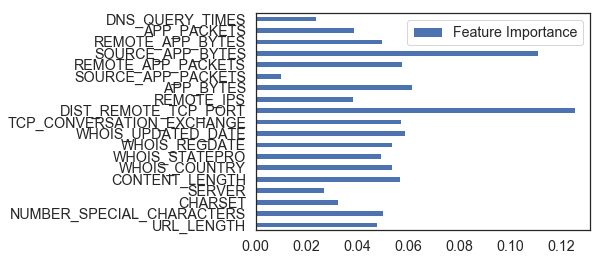

In [12]:
feat_importance = rf_model.feature_importances_ # this feature is an array with the relative importance of the different features
pd.DataFrame({'Feature Importance':feat_importance},
            index=train_df.columns[1:-1]).plot(kind='barh')

In [13]:
param_grid = {
                 'n_estimators': [1, 5, 10, 15, 20],
                 'max_depth': [1, 2, 5, 7, 9],
             }

In [14]:
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(train_df.ix[:,:-1],train_df.Type)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 15, 20], 'max_depth': [1, 2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [16]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 20}

In [17]:
grid_clf.best_score_

1.0

In [18]:
accuracy = accuracy_score(test_df.Type, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 89.08%


**2. Changing the number of folds in the cross-validator for Random Forest**

In [19]:
rf_model_tune = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy', max_depth = 7)
rf_model_tune.fit(train_df.ix[:,1:-1],train_df.Type)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [20]:
predicted_labels_tune = rf_model_tune.predict(test_df.ix[:,1:-1])
accuracy1 = accuracy_score(test_df.Type, predicted_labels_tune)
print("Accuracy: {0:.2%}".format(accuracy1))


Accuracy: 91.32%


In [21]:
grid_clf2 = GridSearchCV(rf_model, param_grid, cv=5)
grid_clf2.fit(train_df.ix[:,:-1],train_df.Type)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 15, 20], 'max_depth': [1, 2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
grid_clf2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [23]:
grid_clf2.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [24]:
rf_model_tune1 = skens.RandomForestClassifier(n_estimators=15,oob_score=True, criterion='entropy', max_depth = 7)
rf_model_tune1.fit(train_df.ix[:,1:-1],train_df.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [25]:
predicted_labels_tune1 = rf_model_tune1.predict(test_df.ix[:,1:-1])
accuracy2 = accuracy_score(test_df.Type, predicted_labels_tune1)
print("Accuracy: {0:.2%}".format(accuracy2))


Accuracy: 90.48%


In [26]:
grid_clf3 = GridSearchCV(rf_model, param_grid, cv=35)
grid_clf3.fit(train_df.ix[:,:-1],train_df.Type)

GridSearchCV(cv=35, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 15, 20], 'max_depth': [1, 2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [27]:
grid_clf3.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
grid_clf3.best_params_

{'max_depth': 5, 'n_estimators': 15}

In [29]:
rf_model_tune2 = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy', max_depth = 5)
rf_model_tune2.fit(train_df.ix[:,1:-1],train_df.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [30]:
predicted_labels_tune2 = rf_model_tune2.predict(test_df.ix[:,1:-1])
accuracy3 = accuracy_score(test_df.Type, predicted_labels_tune2)
print("Accuracy: {0:.2%}".format(accuracy3))

Accuracy: 91.32%


**3. Tuning Random Forest by varying hyperparameters to best ones**

In [31]:
rf_model_best = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy', max_depth = 7)
rf_model_best.fit(train_df.ix[:,1:-1],train_df.Type)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [32]:
predicted_labels_best = rf_model_best.predict(test_df.ix[:,1:-1])
accuracy4 = accuracy_score(test_df.Type, predicted_labels_best)
print("Accuracy: {0:.2%}".format(accuracy4))

Accuracy: 91.04%


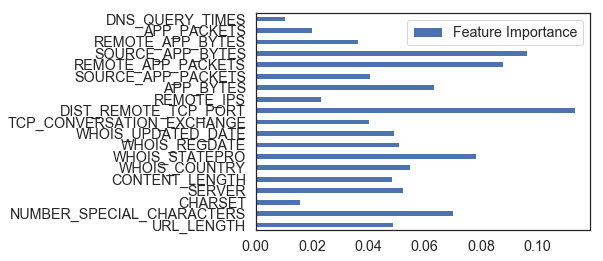

In [33]:
feat_importance = rf_model_best.feature_importances_ # this feature is an array with the relative importance of the different features
pd.DataFrame({'Feature Importance':feat_importance},
            index=train_df.columns[1:20]).plot(kind='barh')

# Naive Bayes


In [43]:
# train_df['is_benign'] = np.where(train_df['Type'] == 0, 0, 1)
# train_df.sample(10)

In [44]:
# test_df['is_benign'] = np.where(test_df['Type'] == 0, 0, 1)
# test_df.sample(10)

In [50]:
variables = list(train_df)
variables_train = variables[1:20]

**1. Building the Naive Bayes classifier**

In [51]:
# train the model
gnb_model = sknb.GaussianNB()
gnb_model.fit(train_df[variables_train],train_df['Type'])

GaussianNB(priors=None)

In [54]:
# test the model
y_pred = gnb_model.predict(test_df[variables_train])


In [55]:
accuracy5 = accuracy_score(test_df.Type, y_pred)
print("Accuracy: {0:.2%}".format(accuracy5))

Accuracy: 33.05%


**4. Experimenting with setting  the appropriate values for priors in the NB model**

In [56]:
type_0 = train_df[train_df['Type'] == 0]
type_1 = train_df[train_df['Type'] == 1]
total_len = len(train_df['Type'])
print(len(type_0), len(type_1), total_len)

1258 166 1424


In [57]:
priors_0 = len(type_0)/total_len
print(priors_0)
priors_1 = len(type_1)/total_len
print(priors_1)

0.8834269662921348
0.11657303370786516


** - Priors as the actual proportions of Type values**

In [58]:
gnb_model_priors = sknb.GaussianNB(priors = [priors_0, priors_1])
gnb_model_priors.fit(train_df[variables_train],train_df['Type'])

GaussianNB(priors=[0.8834269662921348, 0.11657303370786516])

In [60]:
y_pred2 = gnb_model_priors.predict(test_df[variables_train])


In [61]:
accuracy6 = accuracy_score(test_df.Type, y_pred2)
print("Accuracy: {0:.2%}".format(accuracy6))

Accuracy: 33.05%


** - Changing priors to lower value of proportion of type=0**

In [62]:
gnb_model_priors1 = sknb.GaussianNB(priors = [0.20, 0.80])
gnb_model_priors1.fit(train_df[variables_train],train_df['Type'])

GaussianNB(priors=[0.2, 0.8])

In [63]:
y_pred3 = gnb_model_priors1.predict(test_df[variables_train])
accuracy7 = accuracy_score(test_df.Type, y_pred3)
print("Accuracy: {0:.2%}".format(accuracy7))

Accuracy: 30.25%


In [64]:
y_pred2 == y_pred3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,

** - Changing priors to higher value of proportion of type = 0**

In [65]:
gnb_model_priors2 = sknb.GaussianNB(priors = [0.99, 0.01])
gnb_model_priors2.fit(train_df[variables_train],train_df['Type'])

GaussianNB(priors=[0.99, 0.01])

In [67]:
y_pred4 = gnb_model_priors2.predict(test_df[variables_train])
accuracy8 = accuracy_score(test_df.Type, y_pred4)
print("Accuracy: {0:.2%}".format(accuracy8))

Accuracy: 33.89%


# 6. Summary of Findings

* A total of 4 Random Forest classifiers and 4 Naive Bayes classifiers were built to predict the TYPE variable in the dataset. Of the 4 Random Forest classifiers, the number of folds in the cross validator were varied with cv=10, cv=5, and cv=35. Each variation of cross validators was used to identify the best hyperparameters of max_depth and n_estimators, which were then added as parameters for new classifiers. An accuracy score was calculated for each of these models, which were as follows:
    * cv = 10, max_depth and n_estimators not specified: Accuracy = 89.92%
    * cv = 10, max_depth = 7, n_estimators = 20: Accuracy = 91.04%
    * cv = 5, max_depth = 7, n_estimators = 15: Accuracy = 90.40%
    * cv = 35, max_depth = 5, n_estimators = 20: Accuracy = 89.64%
    
    
* Of the 4 Random Forest classifiers, the model was ultimately tuned using the hyperparameters of max_depth = 7 and n_estimators = 20, as this gave the highest accuracy score at the time this code was run. The classifier with these hyperparameters ultimately had an accuracy score of 90.76%.

* The most important features based on my final Random Forest classifier were DIST_REMOTE_TCP_PORT, REMOTE_APP_PACKETS, and SOURCE_APP_BYTES. DIST_REMOTE_TCP_PORT refers to the number of  ports detected and different to TCP (Transmission Control Protocol). REMOTE_APP_PACKETS refers to packets received from the server. SOURCE_APP_BYTES refers to the number of bytes transfered to the server from the honeypot.

* A Naive Bayes classifer was also built to predict the TYPE variable using the "is_benign" column. The initial classifier gave an Accuracy score of 33.05%, which is quite low compared to the Random Forest classifiers. 

* I then experimented with setting different values for the priors (proportions of the TYPE column with type=0 and type=1), initially based on the actual proportions of the TYPE values in the training data set. The initial values/proportions used for the priors were 0.8834 and 0.1166 for type=0 and type=1 respectively. This also yielded an accuracy score of 33.05%. I then changed the priors to be 0.20 and 0.80, and 0.99 and 0.01 respectively. Both of these classifiers  gave Accuracy Scores of 30.25% and 33.89% respectively. So the accuracy did change based on the priors included as parameters in the classifier, and in any case, the accuracy scores for the Naive Bayes classifiers seemed significantly lower than the Random Forest classifiers.

* Across all 8 classifiers created using both the Random Forest and Naive Bayes methods, the Random Forest classifiers appeared to give significantly better results, which was evidenced by the larger accuracy scores. The Random Forest classifier with hyperparameters of max_depth = 7 and n_estimators = 20 in particular gave the highest accuracy. While this classifer gave the highest results, several methods could be used to improve the results of the model overall. In general, 3 techniques are commonly used to improve machine learning models: accessing addition data points/variables, tuning the hyperparameters of the algorithm, or trying different algorithms altogether. In the first technique, although we were given 20 different columns or dependent variables with which our model was built, including additional data points and explanatory variables in our model would likely help to improve the accuracy of the results, as there would be a larger dataset from which to make predictions on the test dataset. In the second technique, it would also help to finetune the hyperparameters used in the algorithm. In the scope of this assignment, a limited range of parameters were used in the params_grid to identify the best estimators, and a limited range of cross validators were also used. Ideally, one would have time to experiment with infinite possible combinations of max_depth and n_estimator values to find the ideal combination that gives the highest accuracy score, and also to identify the best combination of column variables from the training dataset to include in the model to also give the best accuracy score. Lastly, other techniques such as neural networks may improve our results, as these have been shown to be more accurate depending on the type of data available/used.